In [1]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

path='images/images/'

# 
# read all files in train
train_files = os.listdir(path)
train_files = [f for f in train_files if f.endswith('.jpg')]

labels=[]

for f in train_files:
    label_splitted = f.split('_')
    if len(label_splitted) ==2:
        label = label_splitted[0]
    else:
        label = label_splitted[0] + '_' + label_splitted[1]
    labels.append(label)

In [2]:
len(labels)/37

199.72972972972974

In [3]:
import neptune



In [4]:
class_to_idx = {c:i for i,c in enumerate(np.unique(labels))}
idx_to_class = {i:c for c,i in class_to_idx.items()}

num_classes= len(class_to_idx)

In [5]:
from joblib import Parallel, delayed
def load_image(file):
    image = Image.open(path + file)
    #reszie image to 224x224

    # convert to rgb
    if image.mode != 'RGB':
        image = image.convert('RGB')

    label_splitted = file.split('_')
    if len(label_splitted) ==2:
        y = label_splitted[0]
    else:
        y = label_splitted[0] + '_' + label_splitted[1]
    y=class_to_idx[y]
    y=torch.tensor(int(y), dtype=torch.long)
    return (image,y)

all_images= Parallel(n_jobs=16)(delayed(load_image)(f) for f in tqdm(train_files))

  0%|          | 0/7390 [00:00<?, ?it/s]

In [6]:
import torchvision.transforms as transforms

many_transforms= transforms.Compose([
    # horizontal flip
    transforms.RandomHorizontalFlip(),
    # random rotation, mirror fill
    transforms.RandomRotation(30, expand=False, center=None, fill=None),
    # change brightness, saturation, hue
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.07),
    # random perspective
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # imagenet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


minimal_transforms= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

current_transforms = many_transforms

/home/bernd/anaconda3/envs/torch_linux/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/bernd/anaconda3/envs/torch_linux/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [7]:

class Dataset:
    def __init__(self, images_and_labels, transforms=None):
        self.images_and_labels = images_and_labels
        self.size = len(images_and_labels)
        self.transforms=transforms
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        try:
            x,y=self.images_and_labels[idx]
            if self.transforms:
                x = self.transforms(x)
                x = x/255.0
        except:
            print(f'Error at index {idx}, len of dataset is {self.size}') 
            raise
        return x, y

train_dataset = Dataset(all_images, transforms=current_transforms)
x, y = train_dataset[6000]
print(x.shape)

torch.Size([3, 224, 224])


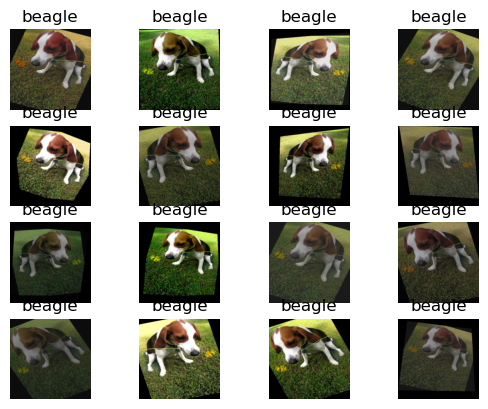

In [8]:
fig, ax= plt.subplots(4, 4)

for i in range(16):
    x,y=train_dataset[999]
    x=x*255.0
    #revert imagenet normalization
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])
    x=x*std[:, None, None]+mean[:, None, None]
    ax[i//4, i%4].imshow(x.permute(1,2,0))
    ax[i//4, i%4].set_title(idx_to_class[y.item()])
    ax[i//4, i%4].axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

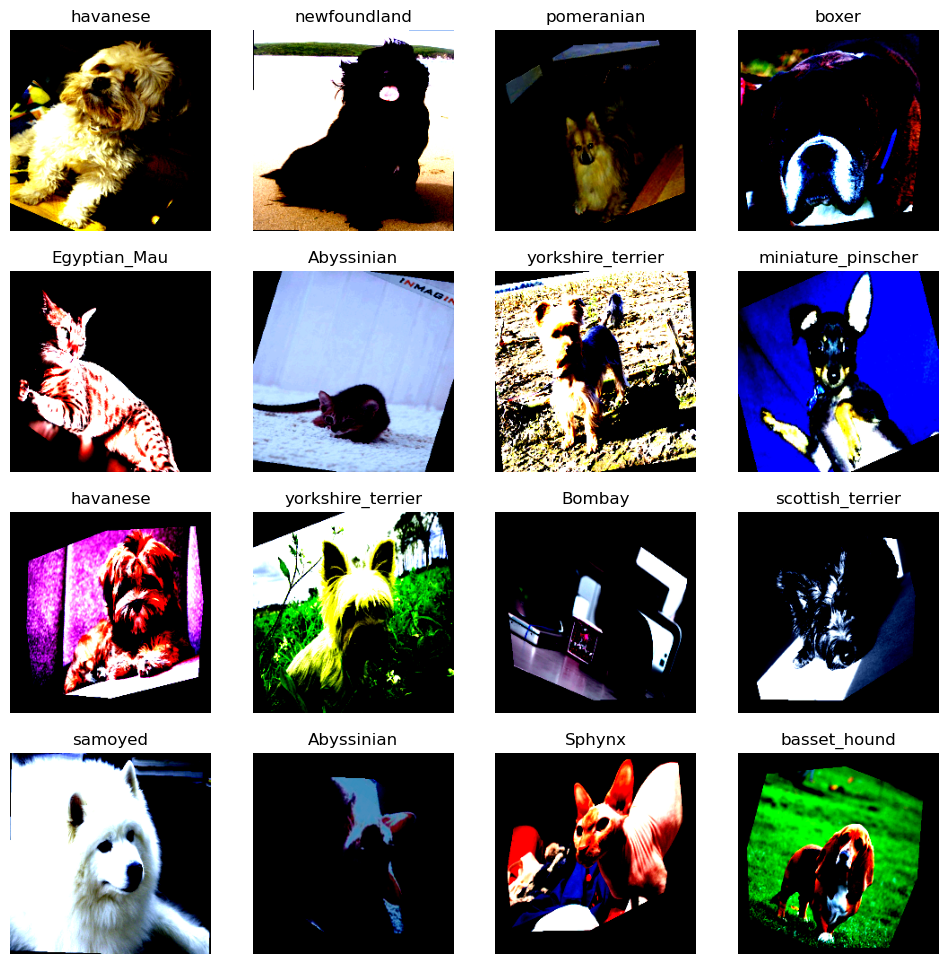

In [9]:
sample_loader= torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

fig, ax= plt.subplots(4,4, figsize=(12,12))
for x,y in sample_loader:
    for i in range(16):
        xi= x[i].permute(1,2,0).numpy()
        xi= xi*255.0
        ax[i//4, i%4].imshow(xi)
        ax[i//4, i%4].set_title(idx_to_class[y[i].item()])
        #remove axis
        ax[i//4, i%4].axis('off')
    break

In [10]:
import torchvision
from torchvision.models import ResNet18_Weights

class CatsAndDogsModel(torch.nn.Module):
    def __init__(self, hidden_size=None, dropout=0.4):
        super().__init__()
        self.backbone=torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.backbone.fc=torch.nn.Sequential(
            torch.nn.Linear(512, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.Linear(hidden_size, num_classes)
        )
        self.freeze()

    def freeze(self):
        for param in self.backbone.parameters():
            param.requires_grad=False
        for param in self.backbone.fc.parameters():
            param.requires_grad=True

    def unfreeze(self):
        for param in self.backbone.parameters():
            param.requires_grad=True
 
    def forward(self, x):
        x=self.backbone(x)
        return x
    
# wir bauen das Modell
model=CatsAndDogsModel(hidden_size=1000)
# wir bauen das Dataset
dataset_sample=Dataset(all_images, transforms=current_transforms)
# wir bauen den DataLoader
loader=torch.utils.data.DataLoader(dataset_sample, batch_size=13, shuffle=True)
# ein einziges Batch-Beispiel wird aus dem Dataloader geladen
for xb, yb in loader:
    print(model(xb).shape)
    assert model(xb).shape==torch.Size([13, num_classes]), "Error: model(xb).shape!=torch.Size([13, 10])"
    break



torch.Size([13, 37])


In [11]:

# split data into train and validation, using 80% for training and 20% for validation
# shuffled
train_idxs=np.random.choice(range(len(all_images)), int(0.8*len(all_images)), replace=False)
train_images=[all_images[i] for i in train_idxs]
validation_images=[all_images[i] for i in range(len(all_images)) if i not in train_idxs]

train_dataset=Dataset(train_images, transforms=current_transforms)

import torchvision
valid_transforms= torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    #imagenet normalization
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_dataset=Dataset(validation_images, transforms=valid_transforms)

In [12]:
print(len(train_dataset), len(valid_dataset))

5912 1478


In [15]:
def get_accuracy(model, dataset):
    loader=torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)   
            y_pred=model(xb)
            y_pred=torch.argmax(y_pred, dim=1)
            correct+=(y_pred==yb).sum().item()
            total+=len(yb)
    return correct/total

hidden_size=1000

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
model=CatsAndDogsModel(hidden_size).to(device)
model.load_state_dict(torch.load('best_model.pth'))
get_accuracy(model, valid_dataset)

0.9851150202976996

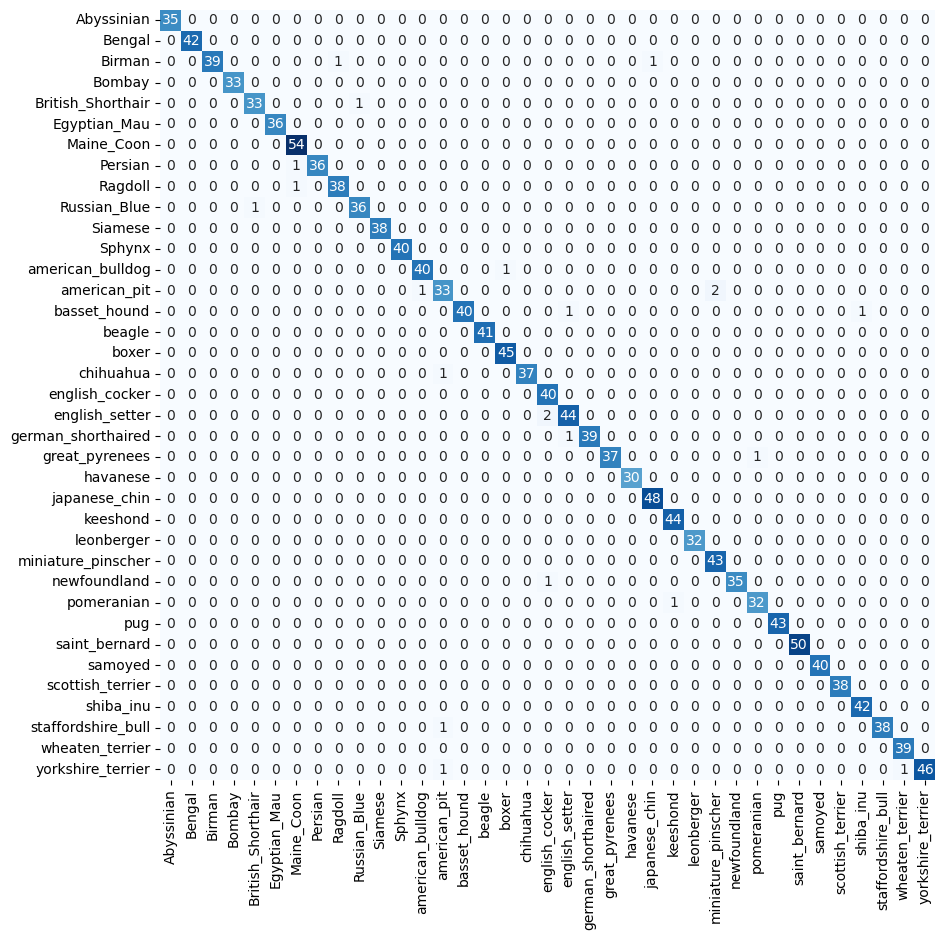

In [17]:
# get confusion matrix for validation dataset

from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_confusion_matrix(model, dataset):
    model.eval()
    y_true=[]
    y_pred=[]
    loader=torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            y_pred.append(torch.argmax(model(xb), dim=1).cpu())
            y_true.append(yb.cpu())
    y_true=torch.cat(y_true)
    y_pred=torch.cat(y_pred)
    return confusion_matrix(y_true, y_pred)

confusion_matrix=get_confusion_matrix(model, valid_dataset)
plt.figure(figsize=(10,10))

class_names=[idx_to_class[i] for i in range(num_classes)]
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.show()


In [18]:
# show top 3 confusion pairs
import numpy as np
confusion_matrix=np.array(confusion_matrix)
np.fill_diagonal(confusion_matrix, 0)
top3=np.argsort(confusion_matrix, axis=None)[-3:]
top3=np.unravel_index(top3, confusion_matrix.shape)
for i in range(3):
    print(f'{class_names[top3[0][i]]} vs {class_names[top3[1][i]]}: {confusion_matrix[top3[0][i], top3[1][i]]} samples')

staffordshire_bull vs american_pit: 1 samples
english_setter vs english_cocker: 2 samples
american_pit vs miniature_pinscher: 2 samples
